# Amazon RecSys GNN - SimGCL Training
## Simple Graph Contrastive Learning with Weighted BPR Loss

This notebook implements:
- **SimGCL**: Contrastive Learning to overcome data sparsity
- **Weighted BPR Loss**: Rating information as loss weights
- **Combined Strategy**: Sparsity solution + Rating utilization

In [1]:
# Imports & Setup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import pickle
import time
import warnings
import os

warnings.filterwarnings('ignore')

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Random Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
# Model Definitions (SimGCL)
print("LightGCN + SimGCL (Contrastive Learning) 모델 정의")
print("="*60)

class LightGCN_SimGCL(nn.Module):
    """
    LightGCN with Simple Graph Contrastive Learning (SimGCL)
    
    희소한 데이터에서 강건한 임베딩을 학습하기 위해 Contrastive Learning 적용.
    학습 시 임베딩에 노이즈를 추가하여 데이터 증강 효과를 얻습니다.
    """
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=3, eps=0.1):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.eps = eps  # Noise level for perturbation
        
        # Embedding Layers
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight, perturbed=False):
        """
        Graph Convolution 수행
        
        Args:
            edge_index: [2, num_edges]
            edge_weight: [num_edges]
            perturbed: True이면 노이즈가 섞인 임베딩 반환
        
        Returns:
            user_emb: [n_users, emb_dim]
            item_emb: [n_items, emb_dim]
        """
        # 초기 임베딩
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        
        # Perturbation (노이즈 추가)
        if perturbed and self.training:
            random_noise = torch.randn_like(all_emb).to(all_emb.device)
            all_emb = all_emb + torch.sign(all_emb) * F.normalize(random_noise, dim=-1) * self.eps
        
        embs = [all_emb]
        
        # Layer-wise Propagation
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        # Layer Combination
        final_emb = torch.mean(torch.stack(embs), dim=0)
        user_emb = final_emb[:self.n_users]
        item_emb = final_emb[self.n_users:]
        
        return user_emb, item_emb
    
    def get_perturbed_embeddings(self, edge_index, edge_weight):
        """
        두 개의 perturbed view 생성 (Contrastive Learning용)
        """
        u_emb_1, i_emb_1 = self.forward(edge_index, edge_weight, perturbed=True)
        u_emb_2, i_emb_2 = self.forward(edge_index, edge_weight, perturbed=True)
        return u_emb_1, i_emb_1, u_emb_2, i_emb_2
    
    def predict(self, user_idx, item_idx, edge_index, edge_weight):
        """예측 점수 (추론 시 사용, perturbed=False)"""
        user_emb, item_emb = self.forward(edge_index, edge_weight, perturbed=False)
        scores = (user_emb[user_idx] * item_emb[item_idx]).sum(dim=-1)
        return scores

print("✅ LightGCN_SimGCL 클래스 정의 완료")

#%%
print("\n" + "="*60)
print("InfoNCE Loss (Contrastive Loss) 함수 정의")
print("="*60)

def compute_infonce_loss(emb_1, emb_2, temperature=0.2):
    """
    InfoNCE Loss for Contrastive Learning
    
    Args:
        emb_1: [batch_size, emb_dim] - First view
        emb_2: [batch_size, emb_dim] - Second view
        temperature: Temperature parameter
    
    Returns:
        loss: Scalar contrastive loss
    """
    # Normalize embeddings
    emb_1 = F.normalize(emb_1, dim=-1)
    emb_2 = F.normalize(emb_2, dim=-1)
    
    batch_size = emb_1.shape[0]
    
    # Positive pairs: (emb_1[i], emb_2[i])
    pos_score = (emb_1 * emb_2).sum(dim=-1) / temperature  # [batch_size]
    
    # All pairs: emb_1 @ emb_2.T
    all_scores = torch.matmul(emb_1, emb_2.t()) / temperature  # [batch_size, batch_size]
    
    # InfoNCE: -log(exp(pos) / sum(exp(all)))
    loss = -torch.log(
        torch.exp(pos_score) / torch.exp(all_scores).sum(dim=1)
    ).mean()
    
    return loss

print("✅ InfoNCE Loss 함수 정의 완료")

#%%
print("\n" + "="*60)
print("모델 테스트")
print("="*60)

# 더미 데이터로 테스트

LightGCN + SimGCL (Contrastive Learning) 모델 정의
✅ LightGCN_SimGCL 클래스 정의 완료

InfoNCE Loss (Contrastive Loss) 함수 정의
✅ InfoNCE Loss 함수 정의 완료

모델 테스트


1. 환경 설정
Device: cuda

하이퍼파라미터:
  임베딩 차원: 64
  레이어 수: 3
  학습률: 0.001
  배치 크기: 2048
  Epochs: 100
  Noise (eps): 0.1
  Lambda CL: 0.2

2. 데이터 로드
Train: 451,598
Val: 70,050
Test: 46,615

그래프 정보:
  유저 수: 256,009
  아이템 수: 74,233
  엣지 수: 903,196

3. Negative Sampling 함수
✅ Negative Sampling 함수 정의 완료

4. 평가 함수
✅ 평가 함수 정의 완료

5. SimGCL 모델 학습
학습 시작...
Epoch 5/100 | Loss: 1.2180 | BPR: 0.6225 | CL: 2.9779 | Val Recall@20: 0.3712 | Val NDCG@20: 0.1683
Epoch 10/100 | Loss: 0.8591 | BPR: 0.2655 | CL: 2.9679 | Val Recall@20: 0.4347 | Val NDCG@20: 0.2028
Epoch 15/100 | Loss: 0.7299 | BPR: 0.1408 | CL: 2.9457 | Val Recall@20: 0.4601 | Val NDCG@20: 0.2184
Epoch 20/100 | Loss: 0.6712 | BPR: 0.0845 | CL: 2.9336 | Val Recall@20: 0.4738 | Val NDCG@20: 0.2272
Epoch 25/100 | Loss: 0.6399 | BPR: 0.0547 | CL: 2.9261 | Val Recall@20: 0.4823 | Val NDCG@20: 0.2328
Epoch 30/100 | Loss: 0.6213 | BPR: 0.0373 | CL: 2.9202 | Val Recall@20: 0.4870 | Val NDCG@20: 0.2359
Epoch 35/100 | Loss: 0.6097 | BPR: 0.0265 | CL: 2.

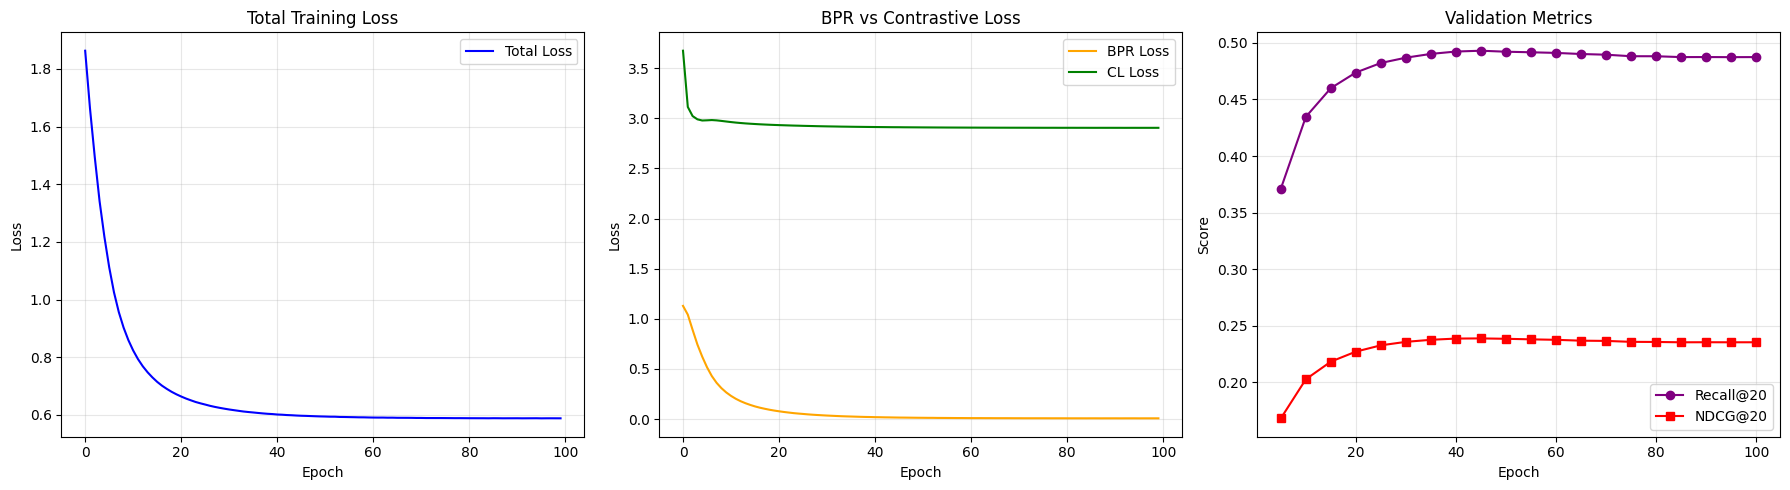

✅ 학습 곡선 저장 완료 (outputs/simgcl_training_curves.png)

7. 최종 모델 저장
✅ 모델 저장 완료:
  - models/simgcl_best.pt
  - models/simgcl_final.pt

✅ SimGCL 학습 파이프라인 실행 완료!


In [3]:
# Training Pipeline (SimGCL)
#%%
"""
SimGCL 학습 파이프라인 - Amazon RecSys GNN
LightGCN + Sim GCL (Contrastive Learning) + Weighted BPR Loss
"""
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import pickle
import time
import warnings
from pathlib import Path
import sys

# 모듈 경로 추가

warnings.filterwarnings('ignore')

# 한글 폰트
# plt.rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

#%%
print("="*60)
print("1. 환경 설정")
print("="*60)

# Random Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Device: {device}")

# Hyperparameters
EMB_DIM = 64
N_LAYERS = 3
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 100
BATCH_SIZE = 2048
NUM_NEG = 4
HARD_NEG_RATIO = 0.5

# SimGCL 전용 하이퍼파라미터
EPS = 0.1  # Noise level for perturbation
LAMBDA_CL = 0.2  # Contrastive loss weight
TEMPERATURE = 0.2  # Temperature for InfoNCE

print(f"\n하이퍼파라미터:")
print(f"  임베딩 차원: {EMB_DIM}")
print(f"  레이어 수: {N_LAYERS}")
print(f"  학습률: {LR}")
print(f"  배치 크기: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Noise (eps): {EPS}")
print(f"  Lambda CL: {LAMBDA_CL}")

#%%
print("\n" + "="*60)
print("2. 데이터 로드")
print("="*60)

# 분할 데이터
train_df = pd.read_csv('/kaggle/input/amazon/train_split.csv')
val_df = pd.read_csv('/kaggle/input/amazon/val_split.csv')
test_df = pd.read_csv('/kaggle/input/amazon/test_split.csv')

print(f"Train: {len(train_df):,}")
print(f"Val: {len(val_df):,}")
print(f"Test: {len(test_df):,}")

# 그래프 데이터
graph_data = torch.load('/kaggle/input/amazon/train_graph.pt')
edge_index = graph_data['edge_index'].to(device)
cca_edge_weight = graph_data['cca_weight'].to(device)
n_users = graph_data['n_users']
n_items = graph_data['n_items']

print(f"\n그래프 정보:")
print(f"  유저 수: {n_users:,}")
print(f"  아이템 수: {n_items:,}")
print(f"  엣지 수: {edge_index.shape[1]:,}")

#%%
print("\n" + "="*60)
print("3. Negative Sampling 함수")
print("="*60)

def fast_sample_negatives(batch_size, num_neg=4):
    """빠른 랜덤 negative sampling"""
    return torch.randint(0, n_items, (batch_size, num_neg), device=device)

@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    """Hard Negative Sampling"""
    batch_size = len(pos_users)
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    
    user_expanded = user_emb[pos_users].unsqueeze(1)
    item_candidates = item_emb[candidates]
    scores = (user_expanded * item_candidates).sum(dim=2)
    
    _, top_indices = scores.topk(num_neg, dim=1)
    hard_negs = candidates.gather(1, top_indices)
    
    return hard_negs

print("✅ Negative Sampling 함수 정의 완료")

#%%
print("\n" + "="*60)
print("4. 평가 함수")
print("="*60)

@torch.no_grad()
def evaluate_recall_ndcg(model, eval_df, edge_index, edge_weight, k_list=[20, 50]):
    """Recall@K 및 NDCG@K 평가"""
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight, perturbed=False)
    
    user_groups = eval_df.groupby('user_idx')
    
    recall_at_k = {k: [] for k in k_list}
    ndcg_at_k = {k: [] for k in k_list}
    
    for user_idx, group in user_groups:
        gt_items = set(group['item_idx'].values)
        
        user_vec = u_emb[user_idx]
        scores = (user_vec @ i_emb.t()).cpu().numpy()
        
        for k in k_list:
            top_k_items = np.argsort(scores)[-k:][::-1]
            
            # Recall@K
            hits = len(set(top_k_items) & gt_items)
            recall = hits / len(gt_items) if len(gt_items) > 0 else 0
            recall_at_k[k].append(recall)
            
            # NDCG@K
            dcg = sum([1 / np.log2(i + 2) if item in gt_items else 0 
                      for i, item in enumerate(top_k_items)])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(gt_items)))])
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_at_k[k].append(ndcg)
    
    metrics = {}
    for k in k_list:
        metrics[f'Recall@{k}'] = np.mean(recall_at_k[k])
        metrics[f'NDCG@{k}'] = np.mean(ndcg_at_k[k])
    
    return metrics

print("✅ 평가 함수 정의 완료")

#%%
print("\n" + "="*60)
print("5. SimGCL 모델 학습")
print("="*60)

# 모델 초기화
model = LightGCN_SimGCL(n_users, n_items, EMB_DIM, N_LAYERS, eps=EPS).to(device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# 학습 데이터
train_users = torch.LongTensor(train_df['user_idx'].values).to(device)
train_items = torch.LongTensor(train_df['item_idx'].values).to(device)
train_ratings = torch.FloatTensor(train_df['rating'].values).to(device)

# [핵심] Rating을 가중치로 변환 (1점=0.5x, 3점=1.0x, 5점=2.0x)
# Formula: weight = 0.3 + 0.34 * rating (1점: 0.64, 3점: 1.32, 5점: 2.0)
train_weights = 0.3 + 0.34 * train_ratings
train_weights = train_weights.to(device)

# 학습 이력
history = {
    'loss': [], 
    'bpr_loss': [], 
    'cl_loss': [],
    'val_recall@20': [], 
    'val_ndcg@20': []
}

print("학습 시작...")
best_val_recall = 0
patience_counter = 0
PATIENCE = 15

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(len(train_users), device=device)
    epoch_loss = 0
    epoch_bpr = 0
    epoch_cl = 0
    n_batches = 0
    
    for i in range(0, len(train_users), BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_users[batch_idx]
        pos_i = train_items[batch_idx]
        weights = train_weights[batch_idx]
        
        # ========== Weighted BPR Loss ==========
        u_emb, i_emb = model(edge_index, cca_edge_weight, perturbed=False)
        
        # Hard + Random Negative Sampling
        n_hard = int(NUM_NEG * HARD_NEG_RATIO)
        hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
        rand_negs = fast_sample_negatives(len(batch_idx), NUM_NEG - n_hard)
        neg_i = torch.cat([hard_negs, rand_negs], dim=1)
        
        # BPR Loss with Rating Weights
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        diff = pos_scores.unsqueeze(1) - neg_scores
        loss_bpr_per_sample = -torch.log(torch.sigmoid(diff) + 1e-8).mean(dim=1)
        loss_bpr = (loss_bpr_per_sample * weights).mean()
        
        # ========== Contrastive Loss (InfoNCE) ==========
        # Perturbed views 생성
        u_emb_1, i_emb_1, u_emb_2, i_emb_2 = model.get_perturbed_embeddings(edge_index, cca_edge_weight)
        
        # User Contrastive Loss (배치 내에서)
        u_cl = compute_infonce_loss(u_emb_1[pos_u], u_emb_2[pos_u], temperature=TEMPERATURE)
        
        # Item Contrastive Loss (배치 내에서)
        i_cl = compute_infonce_loss(i_emb_1[pos_i], i_emb_2[pos_i], temperature=TEMPERATURE)
        
        loss_cl = (u_cl + i_cl) / 2
        
        # ========== Total Loss ==========
        total_loss = loss_bpr + LAMBDA_CL * loss_cl
        
        # Backward
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        epoch_bpr += loss_bpr.item()
        epoch_cl += loss_cl.item()
        n_batches += 1
    
    scheduler.step()
    avg_loss = epoch_loss / n_batches
    avg_bpr = epoch_bpr / n_batches
    avg_cl = epoch_cl / n_batches
    
    history['loss'].append(avg_loss)
    history['bpr_loss'].append(avg_bpr)
    history['cl_loss'].append(avg_cl)
    
    # Validation (매 5 epoch)
    if (epoch + 1) % 5 == 0:
        val_metrics = evaluate_recall_ndcg(model, val_df, edge_index, cca_edge_weight, k_list=[20])
        history['val_recall@20'].append(val_metrics['Recall@20'])
        history['val_ndcg@20'].append(val_metrics['NDCG@20'])
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | "
              f"BPR: {avg_bpr:.4f} | CL: {avg_cl:.4f} | "
              f"Val Recall@20: {val_metrics['Recall@20']:.4f} | "
              f"Val NDCG@20: {val_metrics['NDCG@20']:.4f}")
        
        # Early Stopping
        if val_metrics['Recall@20'] > best_val_recall:
            best_val_recall = val_metrics['Recall@20']
            patience_counter = 0
            # 모델 저장
            torch.save(model.state_dict(), 'models/simgcl_best.pt')
        else:
            patience_counter += 1
            
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"\n✅ SimGCL 모델 학습 완료 (Best Val Recall@20: {best_val_recall:.4f})")

#%%
print("\n" + "="*60)
print("6. 학습 곡선 시각화")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total Loss
axes[0].plot(history['loss'], label='Total Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Training Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# BPR vs CL Loss
axes[1].plot(history['bpr_loss'], label='BPR Loss', color='orange')
axes[1].plot(history['cl_loss'], label='CL Loss', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('BPR vs Contrastive Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Validation Metrics
if history['val_recall@20']:
    x = np.arange(5, len(history['loss']) + 1, 5)[:len(history['val_recall@20'])]
    axes[2].plot(x, history['val_recall@20'], label='Recall@20', marker='o', color='purple')
    axes[2].plot(x, history['val_ndcg@20'], label='NDCG@20', marker='s', color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Score')
    axes[2].set_title('Validation Metrics')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/simgcl_training_curves.png', dpi=150)
plt.show()

print("✅ 학습 곡선 저장 완료 (outputs/simgcl_training_curves.png)")

#%%
print("\n" + "="*60)
print("7. 최종 모델 저장")
print("="*60)

# 최종 모델 로드 (Best validation)
model.load_state_dict(torch.load('models/simgcl_best.pt'))

# 전체 저장
torch.save({
    'state_dict': model.state_dict(),
    'config': {
        'n_users': n_users,
        'n_items': n_items,
        'emb_dim': EMB_DIM,
        'n_layers': N_LAYERS,
        'eps': EPS
    },
    'history': history
}, 'models/simgcl_final.pt')

print("✅ 모델 저장 완료:")
print("  - models/simgcl_best.pt")
print("  - models/simgcl_final.pt")

print("\n✅ SimGCL 학습 파이프라인 실행 완료!")

# %%
